In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config ZMQInteractiveShell.ast_node_interactivity='all'
%pprint

Pretty printing has been turned ON


In [10]:
# 大小设置
sns.set(rc={'figure.figsize':(13,7)})
# 风格设置
sns.set_style("whitegrid")

goal = 'target'


# 加载数据

In [11]:
df_train = pd.read_table('../data/zhengqi_train.txt', sep='\t')
df_train.head(2)
df_test = pd.read_table('../data/zhengqi_test.txt', sep='\t')
df_test.head(2)
df_test["target"] = 0
df_train["isTrain"] = 1
df_test["isTrain"] = 0
dt = pd.concat([df_train, df_test], ignore_index=True)

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V29,V30,V31,V32,V33,V34,V35,V36,V37,target
0,0.566,0.016,-0.143,0.407,0.452,-0.901,-1.812,-2.36,-0.436,-2.114,...,0.136,0.109,-0.615,0.327,-4.627,-4.789,-5.101,-2.608,-3.508,0.175
1,0.968,0.437,0.066,0.566,0.194,-0.893,-1.566,-2.36,0.332,-2.114,...,-0.128,0.124,0.032,0.600,-0.843,0.160,0.364,-0.335,-0.730,0.676


,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37
0,0.368,0.380,-0.225,-0.049,0.379,0.092,0.550,0.551,0.244,0.904,...,-0.449,0.047,0.057,-0.042,0.847,0.534,-0.009,-0.190,-0.567,0.388
1,0.148,0.489,-0.247,-0.049,0.122,-0.201,0.487,0.493,-0.127,0.904,...,-0.443,0.047,0.560,0.176,0.551,0.046,-0.220,0.008,-0.294,0.104


# 加载数据

In [15]:
def load_data(dt=dt, m_type = 'xgb-model'):
    """
        加载数据，输出放入模型的特征features列表以及特征列表中是类别型的列表cate_feat
        对cate_feat进行了LabelEncoder，针对LGB增加category转化
    """
    # 参考资料：树模型LabelEncoder——https://www.cnblogs.com/ranjiewen/p/9105954.html:

    noise_feature = [goal, 'isTrain']
    category_feature = []
    numeric_feature = [i for i in dt.columns if i not in category_feature + noise_feature]
    
    lbl = LabelEncoder()  
    for col in category_feature:
        dt[col] = lbl.fit_transform(dt[col].astype(str))
    if m_type == 'lgb-model':
        for catf in category_feature:
            dt[catf] = dt[catf].astype('category')         
    features = numeric_feature + category_feature
    train = dt[dt.isTrain==1]
    test = dt[dt.isTrain==0]


    return (train, test, features, category_feature)

# 调参

- 参考资料：https://www.cnblogs.com/pinard/p/6160412.html

In [16]:
print("=> 载入数据中...")
train, test, features, category_feature = load_data(dt=dt, m_type='xgb-model')

=> 载入数据中...


In [17]:
X = train[features]
y = train[goal]

In [18]:

rf0 = RandomForestRegressor(oob_score=True, random_state=2020001)
print('正在拟合...')
rf0.fit(X, y)
print(rf0.oob_score_)
print('整正在预测...')
y_pred = rf0.predict(X)

print('输出MSE:', mean_squared_error(y_true=y, y_pred=y_pred)) 

正在拟合...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=True, random_state=2020001,
                      verbose=0, warm_start=False)

0.8170735128260144
整正在预测...
输出MSE: 0.024457791630886426


## 迭代次数

In [23]:
print("=> 载入数据中...")
print("=> 建模特征列：", features)
print("=> 建模类别特征列：", category_feature)
print("=> 使用RF建模...")

param_test1 = {
    'n_estimators': [200, 500, 800, 1000]
}
gsearch1 = GridSearchCV(estimator = 
                        RandomForestRegressor(min_samples_split=6,
                                              min_samples_leaf=5,
                                              max_depth=8,
                                              random_state=2020002), 
                        param_grid = param_test1, 
                        scoring='neg_mean_squared_error', n_jobs=4, verbose=1, cv=3)

evalute_result = gsearch1.fit(X,y)

print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(gsearch1.best_params_))
print('最佳模型得分:{0}'.format(gsearch1.best_score_))

=> 载入数据中...
=> 建模特征列： ['V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37']
=> 建模类别特征列： []
=> 使用RF建模...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:   57.4s finished


每轮迭代运行结果:GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=8, max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=5,
                                             min_samples_split=6,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False,
                                             random_state=2020002, verbose=0,
                                             warm_start=False),
             iid='warn', n_jobs=4,
             param_grid={'n_estimators': [200, 500

## max_depth与min_samples_split

In [24]:
print("=> 载入数据中...")
print("=> 建模特征列：", features)
print("=> 建模类别特征列：", category_feature)
print("=> 使用RF建模...")

param_test1 = {
    'max_depth': range(6, 11, 1), 
    'min_samples_split': [3, 5, 7, 9]
}
gsearch1 = GridSearchCV(estimator = 
                        RandomForestRegressor(n_estimators=500,
#                                               min_samples_split=6,
#                                               max_depth=8,
                                              min_samples_leaf=5,
                                              random_state=2020002), 
                        param_grid = param_test1, 
                        scoring='neg_mean_squared_error', n_jobs=4, verbose=1, cv=3)

evalute_result = gsearch1.fit(X,y)

print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(gsearch1.best_params_))
print('最佳模型得分:{0}'.format(gsearch1.best_score_))

=> 载入数据中...
=> 建模特征列： ['V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37']
=> 建模类别特征列： []
=> 使用RF建模...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.9min finished


每轮迭代运行结果:GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=5,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=500, n_jobs=None,
                                             oob_score=False,
                                             random_state=2020002, verbose=0,
                                             warm_start=False),
             iid='warn', n_jobs=4,
     

## min_samples_leaf

In [26]:
print("=> 载入数据中...")
print("=> 建模特征列：", features)
print("=> 建模类别特征列：", category_feature)
print("=> 使用RF建模...")

param_test1 = {
    'min_samples_leaf': range(3, 8, 1), 
    'min_samples_split': [2, 3, 4]
}

gsearch1 = GridSearchCV(estimator = 
                        RandomForestRegressor(n_estimators=500,
#                                               min_samples_split=6,
                                              max_depth=10,
#                                               min_samples_leaf=4,
                                              random_state=2020002), 
                        param_grid = param_test1, 
                        scoring='neg_mean_squared_error', n_jobs=4, verbose=1, cv=3)

evalute_result = gsearch1.fit(X,y)

print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(gsearch1.best_params_))
print('最佳模型得分:{0}'.format(gsearch1.best_score_))

=> 载入数据中...
=> 建模特征列： ['V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37']
=> 建模类别特征列： []
=> 使用RF建模...
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.5min finished


每轮迭代运行结果:GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=10, max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=500, n_jobs=None,
                                             oob_score=False,
                                             random_state=2020002, verbose=0,
                                             warm_start=False),
             iid='warn', n_jobs=4,
             param_grid={'min_samples_leaf': range(3

## max_features

In [30]:
print("=> 载入数据中...")
print("=> 建模特征列：", features)
print("=> 建模类别特征列：", category_feature)
print("=> 使用RF建模...")

param_test1 = {
    'max_features':range(10, 17, 1)
}

gsearch1 = GridSearchCV(estimator = 
                        RandomForestRegressor(n_estimators=500,
                                              min_samples_split=4,
                                              max_depth=10,
                                              min_samples_leaf=4,
                                              random_state=2020002), 
                        param_grid = param_test1, 
                        scoring='neg_mean_squared_error', n_jobs=4, verbose=1, cv=3)

evalute_result = gsearch1.fit(X,y)

print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(gsearch1.best_params_))
print('最佳模型得分:{0}'.format(gsearch1.best_score_))

=> 载入数据中...
=> 建模特征列： ['V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37']
=> 建模类别特征列： []
=> 使用RF建模...
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  21 out of  21 | elapsed:   31.1s finished


每轮迭代运行结果:GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=10, max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=4,
                                             min_samples_split=4,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=500, n_jobs=None,
                                             oob_score=False,
                                             random_state=2020002, verbose=0,
                                             warm_start=False),
             iid='warn', n_jobs=4, param_grid={'max_features': range(10, 17)},
        

# 训练与分析

In [32]:
rf1 = RandomForestRegressor(n_estimators= 500, 
                             max_depth=10, 
                             min_samples_split=4,
                             min_samples_leaf=4,
                             max_features=12,
                             oob_score=True, 
                             random_state=2020003)
    
print('正在拟合...')
rf1.fit(X, y)
print(rf1.oob_score_)
print('整正在预测...')
y_pred1 = rf1.predict(X)

print('输出MSE:', mean_squared_error(y_true=y, y_pred=y_pred1)) 

print('测试集预测...')
test_target_pre = rf1.predict(test[features])

正在拟合...


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features=12, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=True, random_state=2020003,
                      verbose=0, warm_start=False)

0.873352138433
整正在预测...
输出MSE: 0.05181592171231468
测试集预测...


# 保存结果

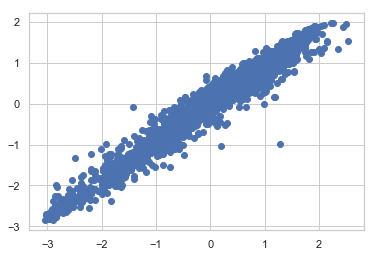

In [33]:
plt.scatter(y, y_pred1)

In [34]:
submission = pd.DataFrame({goal: test_target_pre})
submission.to_csv("../result/sample_submit07-xxxx-rf.txt", sep='\t', index=False, header=False)